**Análisis de Series de Tiempo**

In [156]:
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

**Paso 1:**

*   Los archivos de datos contienen las observaciones promedio diarias. Al principio de cada archivo indica cuantas líneas contiene el encabezado, para considerarlo a la hora de leer el archivo CSV (aquí separado por espacios).
*   Nos interesa la columna de 'value' que corresponde a las concentraciones de CO2. Cuando hay datos faltantes, aparece el número -999.99. Habrá que reemplazarlo por NaN. Las series de tiempo son de mediados de 1970 al 2019-12-31. 
*   Para construir una serie de tiempo que deseamos analizar, se pide construir una columna de 'Fecha' variable de tipo datetime,  combinando las columnas 'year', 'month', y 'day'.
*   Después se pide construir un dataframe que contiene desde el inicio de 1980 hasta fin de 2019.
*   Convierte el dataframe anterior a serie de tiempo 'ts_test', usando 'Fecha' como índice.
*   La serie de tiempo de concentraciones de CO2, sólo deberá tener la Fecha como índice y la columna de CO2.
*   Puedes usar la función de Pandas ts_test.ffill(axis = 0, inplace=True), para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.

In [157]:

#Tomamos la dirección del archivo.
url = 'https://raw.githubusercontent.com/RaulACortez/FisicaComputacional1/main/FisicaComputacional1/Evaluaci%C3%B3n1/Hawaii.txt'

#Definimos nombres para las columnas.
my_cols = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'Concentracion de CO2', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=152, skipfooter=0, engine='python')

#Creamos una copia y conservamos el original.
df_work0 = df_dist.copy()

#reemplazamos los textos "Nulo" por espacio en blanco.
str_Nulo = -999.99
df_work1 = df_work0.replace(to_replace=str_Nulo, value='NaN', regex=True)

#Convertimos los valores de las variables ambientales a numeros flotantes.
cols_list = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'Concentracion de CO2', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')

#Volveremos a hacer una copia.
df_work2 = df_work1.copy()

df_work2['Fecha'] = pd.to_datetime(df_work2[['year','month','day']]
                   .astype(str).apply(' '.join, 1), format='%Y %m %d')

df_work2['Fecha'] = (pd.to_datetime(df_work2['year'].astype(str) + '-' +
                                  df_work2['month'].astype(str) + '-' +
                                  df_work2['day'].astype(str)))


In [158]:
df_datos = df_work2.copy()
df_datos.info()
print(df_datos.head())
print(df_datos.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17166 entries, 0 to 17165
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   site_code             0 non-null      float64       
 1   year                  17166 non-null  int64         
 2   month                 17166 non-null  int64         
 3   day                   17166 non-null  int64         
 4   hour                  17166 non-null  int64         
 5   minute                17166 non-null  int64         
 6   second                17166 non-null  int64         
 7   time_decimal          17166 non-null  float64       
 8   Concentracion de CO2  13936 non-null  float64       
 9   value_std_dev         17166 non-null  float64       
 10  nvalue                17166 non-null  int64         
 11  latitude              17166 non-null  float64       
 12  longitude             17166 non-null  float64       
 13  altitude        

In [159]:
df_datos = df_datos.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_datos = df_datos.set_index('Fecha')
# Vamos a utilizar los últimos de datos, que corresponden al periodo 1980-2019
df_80 = df_datos[(df_datos['year'] >= 1980) & (df_datos['year'] < 2020)]
df_80.head()

,site_code,year,month,day,hour,minute,second,time_decimal,Concentracion de CO2,value_std_dev,nvalue,latitude,longitude,altitude,elevation,intake_height,qcflag
Fecha,,,,,,,,,,,,,,,,,
1980-01-01,NaN,1980,1,1,0,0,0,1980.000000,337.85,0.12,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-02,NaN,1980,1,2,0,0,0,1980.002732,337.32,0.35,11,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-03,NaN,1980,1,3,0,0,0,1980.005464,337.75,0.05,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-04,NaN,1980,1,4,0,0,0,1980.008197,337.70,0.04,15,19.536,-155.576,3437.0,3397.0,40.0,NaN
1980-01-05,NaN,1980,1,5,0,0,0,1980.010929,337.65,0.08,15,19.536,-155.576,3437.0,3397.0,40.0,NaN


In [160]:
df_80co2 = df_80.drop(['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag'], axis=1)
df_80co2.head(10)

,Concentracion de CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65
1980-01-06,337.25
1980-01-07,337.86
1980-01-08,337.31
1980-01-09,NaN


In [185]:
df_80co2.ffill(axis = 0, inplace=True)

**Paso 2:**

*   Define una función para probar estacionaridad utilizando la Prueba Avanzada de Dickey-Fuller: test_stationarity(df_ts)
*   Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.
*   Si no es una serie de tiempo estacionaria, cambia de escala a Log(CO2), y gráfica la nueva función.
*   Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, y promedio móvil de 365 días. Produce las gráficas de las series que la componen. Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las estaciones del año) y residuo (el resto). 
*   Prueba la estacionaridad de la serie residuo.
*   Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo de 365 días y contrastarlo en una gráfica con la serie de Log CO2.
*   Define un nuevo dataframe con la diferencia entre la serie logaritmo original y el promedio móvil, y prueba después su estacionaridad.
*   Adicionalmente, prueba construir una serie estacionaria usando la función de diferenciación shift con un periodo de 7 días, que utiliza menos puntos que el promedio móvil.
*   Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'.
*   Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los parámetros p, q y utiliza d=1 (ya que hemos ya derivado una vez) 
*   Para seleccionar el mejor modelo, calcula el Criterio de Información de Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q).
*   Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.
*   Calcula el error RMSE.
*   Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA para ver mas a detalles el modelo.

In [186]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [187]:
start, end = '1980-01', '2019-12'

ts_80co2 = df_80co2.loc[start:end].copy()
ts_80co2.head()

,Concentracion de CO2
Fecha,
1980-01-01,337.85
1980-01-02,337.32
1980-01-03,337.75
1980-01-04,337.70
1980-01-05,337.65


In [188]:
ts_80['Concentracion de CO2'].head()

Fecha
2012-01-01    392.29
2012-01-02    392.54
2012-01-03    393.18
2012-01-04    393.42
2012-01-05    393.66
Name: Concentracion de CO2, dtype: float64

In [191]:
ts_test = ts_80['Concentracion de CO2'].copy()

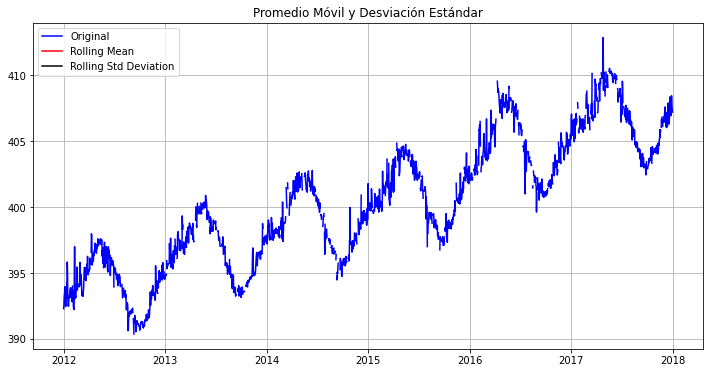

Resultados de la Prueba de Dickey-Fuller:


MissingDataError: ignored

In [192]:
test_stationarity(ts_test)